### Prepare Data

In [1]:
from pandas import read_csv
from datetime import datetime
import os

data_dir = "C:\\UW\\data\\BeijingAirQuality"
raw_data_file = "PRSA_data_2010.1.1-2014.12.31.csv"
raw_data_path = os.path.join(data_dir, raw_data_file)
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv(raw_data_path,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
prepared_data_path = os.path.join(data_dir, "pollution.csv")
dataset.to_csv(prepared_data_path)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


### Load the Prepared Data and Visualize

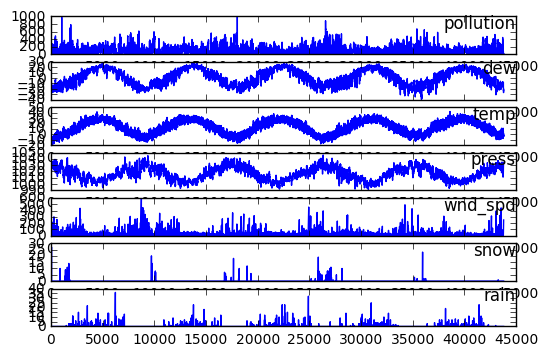

In [3]:
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load dataset
dataset = read_csv(prepared_data_path, header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

### Define a Function to Convert Time Series Forecating to Regression

In [30]:
def series_to_supervised(data, n_in=[1], n_out=[1], dropnan=True):
    import pandas as pd
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    colnames = df.columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if len(n_in) == 1:
        sequence = range(n_in[0], 0, -1)
    else:
        sequence = n_in
    for i in sequence: # Shift the rows downwards
        cols.append(df.shift(i))
        names += [('var%s_t-%d' % (colnames[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    if len(n_out) == 1:
        sequence = range(0, n_out[0])
    else:
        sequence = n_out
    for i in sequence:
        cols.append(df.shift(-i)) # Shift the rows upwards
        if i == 0:
            names += [('var%s_t' % colnames[j]) for j in range(n_vars)]
        else:
            names += [('var%s_t+%d' % (colnames[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1) 
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [90]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# load dataset
dataset = read_csv(prepared_data_path, header=0, index_col=0)
values = dataset.values
# integer encode Wind Direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, [1], [1])
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# Use the following line if series_to_supervised is [1, 24]
#reframed.drop(reframed.columns[[17,18,19,20,21,22,23]], axis=1, inplace=True) #Drop the 7 feature columns at t


print(reframed.head())

   var0_t-1  var1_t-1  var2_t-1  var3_t-1  var4_t-1  var5_t-1  var6_t-1  \
1  0.129779  0.352941  0.245902  0.527273  0.666667  0.002290  0.000000   
2  0.148893  0.367647  0.245902  0.527273  0.666667  0.003811  0.000000   
3  0.159960  0.426471  0.229508  0.545454  0.666667  0.005332  0.000000   
4  0.182093  0.485294  0.229508  0.563637  0.666667  0.008391  0.037037   
5  0.138833  0.485294  0.229508  0.563637  0.666667  0.009912  0.074074   

   var7_t-1    var0_t  
1       0.0  0.148893  
2       0.0  0.159960  
3       0.0  0.182093  
4       0.0  0.138833  
5       0.0  0.109658  


### Split the Data into Training and Validation

In [91]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### Define LSTM Model

In [93]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

### Train LSTM Model

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 4s - loss: 0.0566 - val_loss: 0.0574
Epoch 2/50
 - 2s - loss: 0.0408 - val_loss: 0.0604
Epoch 3/50
 - 2s - loss: 0.0264 - val_loss: 0.0553
Epoch 4/50
 - 2s - loss: 0.0190 - val_loss: 0.0506
Epoch 5/50
 - 3s - loss: 0.0172 - val_loss: 0.0421
Epoch 6/50
 - 3s - loss: 0.0162 - val_loss: 0.0327
Epoch 7/50
 - 2s - loss: 0.0153 - val_loss: 0.0248
Epoch 8/50
 - 2s - loss: 0.0150 - val_loss: 0.0210
Epoch 9/50
 - 2s - loss: 0.0148 - val_loss: 0.0194
Epoch 10/50
 - 3s - loss: 0.0147 - val_loss: 0.0177
Epoch 11/50
 - 3s - loss: 0.0147 - val_loss: 0.0166
Epoch 12/50
 - 2s - loss: 0.0146 - val_loss: 0.0163
Epoch 13/50
 - 2s - loss: 0.0146 - val_loss: 0.0158
Epoch 14/50
 - 3s - loss: 0.0146 - val_loss: 0.0151
Epoch 15/50
 - 2s - loss: 0.0146 - val_loss: 0.0148
Epoch 16/50
 - 3s - loss: 0.0145 - val_loss: 0.0145
Epoch 17/50
 - 2s - loss: 0.0146 - val_loss: 0.0146
Epoch 18/50
 - 3s - loss: 0.0147 - val_loss: 0.0145
Epoch 19/50
 - 2s - loss

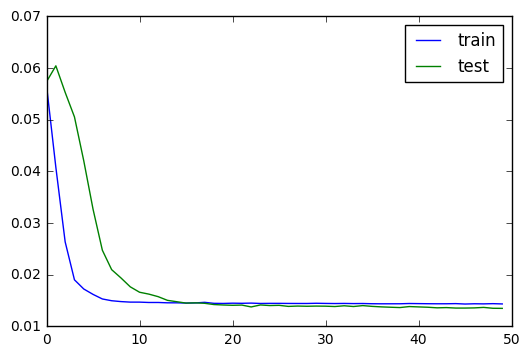

In [94]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluating the Model Performance on Validation Data

In [95]:
from numpy import concatenate, sqrt, mean
if len(test_X.shape) == 2:
    test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:8]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:8]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mape = mean([abs(inv_y[i] - inv_yhat[i])/inv_y[i] for i in range(len(inv_y)) if inv_y[i] > 0]) * 100
print("MAPE=%.2f%%"%mape)

Test RMSE: 26.514
MAPE=22.56%


In [96]:
# If use the pollution in the last 1 hour, and 24 hours ago as features 
# MAPE = 26.37%, RMSE = 26.448
# If just use the pollution in the last 1 hour as features, 
# MAPE= 22.56%, RMSE = 26.514